In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-07-07 08:23:31--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-07 08:23:31 (5.86 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split, model):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  return loss.item() # Return the loss value

In [ ]:
def sample(model):
  for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

E01: using torch.nn module instead of custom classes
BatchNorm removed since I was not able to make them work.

In [ ]:
import torch.nn.init as init

class Model(torch.nn.Module):
  def __init__(self, vocab_size, n_embd, n_hidden):
    super(Model, self).__init__()

    self.embed = torch.nn.Embedding(vocab_size, n_embd)
    self.tanh = torch.nn.Tanh()

    # In torch.nn.BatchNorm1d input is (N,C,L) and not (N,L,C) as in the lecture
    self.batchNorm1 = torch.nn.BatchNorm1d(n_hidden)
    self.batchNorm2 = torch.nn.BatchNorm1d(n_hidden)
    self.batchNorm3 = torch.nn.BatchNorm1d(n_hidden)

    self.fully_connected1 = torch.nn.Linear(n_embd * 2, n_hidden, bias=False)
    init.kaiming_normal_(self.fully_connected1.weight, mode='fan_in', nonlinearity='tanh')
    self.fully_connected2 = torch.nn.Linear(n_hidden * 2, n_hidden, bias=False)
    init.kaiming_normal_(self.fully_connected2.weight, mode='fan_in', nonlinearity='tanh')
    self.fully_connected3 = torch.nn.Linear(n_hidden * 2, n_hidden, bias=False)
    init.kaiming_normal_(self.fully_connected3.weight, mode='fan_in', nonlinearity='tanh')
    self.fully_connected4 = torch.nn.Linear(n_hidden, vocab_size, bias=False)

  def flatten_consecutive(self, x):
    B, T, C = x.shape
    # swap 2nd and 3rd dimensions
    x = x.reshape(B, T // 2, C * 2)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    return x

  def forward(self, x):

    # Embedding
    x = self.embed(x)

    # Block 1
    x = self.flatten_consecutive(x)
    x = self.fully_connected1(x)
    #x = x.permute(0, 2, 1)
    #x = self.batchNorm1(x)
    #x = x.permute(0, 2, 1)
    x = self.tanh(x)

    # Block 2
    x = self.flatten_consecutive(x)
    x = self.fully_connected2(x)
    #x = x.permute(0, 2, 1)
    #x = self.batchNorm2(x)
    #x = x.permute(0, 2, 1)
    x = self.tanh(x)

    # Block 3
    x = self.flatten_consecutive(x)
    x = self.fully_connected3(x)
    #x = x.permute(0, 2, 1)
    #x = self.batchNorm3(x)
    #x = x.permute(0, 2, 1)
    x = self.tanh(x)

    # Block 4
    x = self.fully_connected4(x)

    return x

E02: Beat the 1.993 validation loss

In [ ]:
n_embed = 32
n_hidden = 256

model = Model(vocab_size, n_embed, n_hidden)
model(Xtr[:10]); # Sanity check

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
train_losses = []
dev_losses = []

for epoch in range(100):
    model.train()

    for i in range(0, len(Xtr), 64):
        x = Xtr[i:i+64]
        y = Ytr[i:i+64]

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    train_loss = split_loss('train', model)
    dev_loss = split_loss('val', model)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    scheduler.step(dev_loss)

    print(f"epoch : {epoch} train_loss : {train_loss} dev_loss : {dev_loss}")

train 2.1088225841522217
val 2.1316871643066406
epoch : 0 train_loss : 2.1088225841522217 dev_loss : 2.1316871643066406
train 2.0832934379577637
val 2.1122772693634033
epoch : 1 train_loss : 2.0832934379577637 dev_loss : 2.1122772693634033
train 2.0620555877685547
val 2.0968916416168213
epoch : 2 train_loss : 2.0620555877685547 dev_loss : 2.0968916416168213
train 2.043644666671753
val 2.084162712097168
epoch : 3 train_loss : 2.043644666671753 dev_loss : 2.084162712097168
train 2.027245283126831
val 2.0733542442321777
epoch : 4 train_loss : 2.027245283126831 dev_loss : 2.0733542442321777
train 2.0123674869537354
val 2.0640370845794678
epoch : 5 train_loss : 2.0123674869537354 dev_loss : 2.0640370845794678
train 1.9986984729766846
val 2.055936098098755
epoch : 6 train_loss : 1.9986984729766846 dev_loss : 2.055936098098755
train 1.986025333404541
val 2.048849582672119
epoch : 7 train_loss : 1.986025333404541 dev_loss : 2.048849582672119
train 1.9741960763931274
val 2.042625904083252
epoch

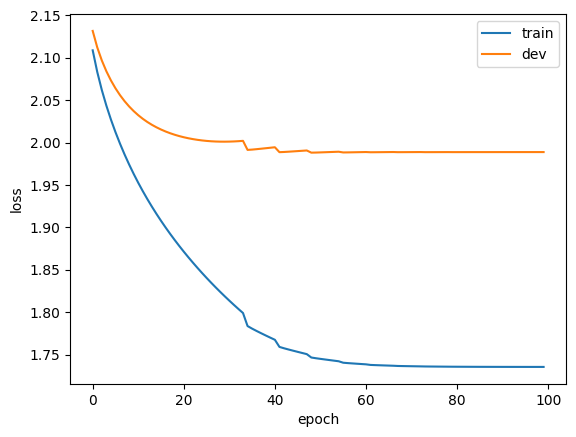

In [ ]:
# plot train and dev losses
plt.plot(train_losses, label = 'train')
plt.plot(dev_losses, label = 'dev')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

In [ ]:
print(f"Training Loss: {split_loss('train', model):0.3f}")
print(f"Validation Loss: {split_loss('val', model):0.3f}")
print(f"Test Loss: {split_loss('test', model):0.3f}")

train 1.7355422973632812
Training Loss: 1.736
val 1.9888463020324707
Validation Loss: 1.989
test 1.9826596975326538
Test Loss: 1.983


In [ ]:
sample(model)

makari.
marganette.
vana.
krishad.
brittolli.
belle.
janisha.
jaksha.
sterlin.
jahaan.
keenaz.
kacyla.
roaidy.
landie.
thernell.
yacien.
abber.
ezra.
tavon.
jamilyn.


E03: Using convolutions

In [ ]:
class ModelCnn(nn.Module):
    def __init__(self, vocab_size, n_embed, n_hidden, n_layers):
        super(ModelCnn, self).__init__()

        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, n_embed)
        self.fc1 = nn.Linear(n_embed, n_hidden, bias=False)

        for i in range(n_layers):
            setattr(self, f"conv1d_{i}", nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=2, stride=2, bias=False, dilation=1, padding=0))
            setattr(self, f"bn{i}", nn.BatchNorm1d(n_hidden))


        self.fc2 = nn.Linear(n_hidden, vocab_size, bias=False)

    def forward(self, x):
        x = self.embedding(x)
        x = self.fc1(x)
        x = F.tanh(x)
        x = x.transpose(1,2)

        for i in range(self.n_layers):
            conv1d = getattr(self, f"conv1d_{i}")
            bn = getattr(self, f"bn{i}")
            x = conv1d(x)

            x = bn(x)
            x = F.tanh(x)

        x = x.squeeze(-1)
        x = self.fc2(x)
        return x

In [ ]:
n_embed = 25
n_hidden = 80

model = ModelCnn(vocab_size= vocab_size, n_embed= n_embed, n_hidden= n_hidden, n_layers= 3)
model(Xtr[:10]);
train_losses = []
dev_losses = []

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

for epoch in range(100):
    model.train()

    for i in range(0, len(Xtr), 64):
        x = Xtr[i:i+64]
        y = Ytr[i:i+64]

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    train_loss = split_loss('train', model)
    dev_loss = split_loss('val', model)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    scheduler.step(dev_loss)

    print(f"epoch : {epoch} train_loss : {train_loss} dev_loss : {dev_loss}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train 2.199551582336426
val 2.2154293060302734
epoch : 0 train_loss : 2.199551582336426 dev_loss : 2.2154293060302734
train 2.170574426651001
val 2.2009072303771973
epoch : 1 train_loss : 2.170574426651001 dev_loss : 2.2009072303771973
train 2.1635613441467285
val 2.20422101020813
epoch : 2 train_loss : 2.1635613441467285 dev_loss : 2.20422101020813
train 2.144472360610962
val 2.1922755241394043
epoch : 3 train_loss : 2.144472360610962 dev_loss : 2.1922755241394043
train 2.122846841812134
val 2.176370859146118
epoch : 4 train_loss : 2.122846841812134 dev_loss : 2.176370859146118
train 2.1033928394317627
val 2.1626245975494385
epoch : 5 train_loss : 2.1033928394317627 dev_loss : 2.1626245975494385
train 2.087158679962158
val 2.1521315574645996
epoch : 6 train_loss : 2.087158679962158 dev_loss : 2.1521315574645996
train 2.074558973312378
val 2.1450998783111572
epoch : 7 train_loss : 2.074558973312378 dev_loss : 2.1450998783111572
train 2.065918445587158
val 2.1418306827545166
epoch : 8 t

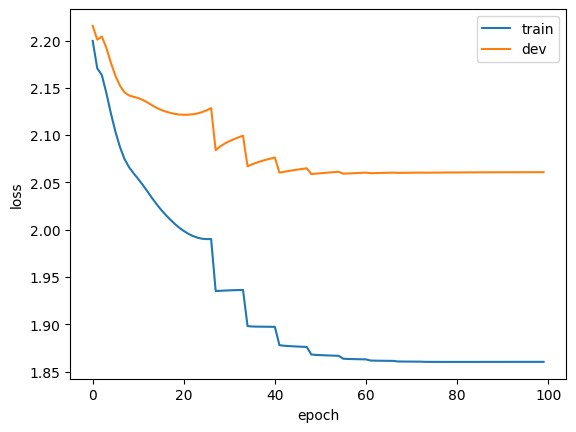

In [ ]:
plt.plot(train_losses, label = 'train')
plt.plot(dev_losses, label = 'dev')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

In [ ]:
print(f"Training Loss: {split_loss('train', model):0.3f}")
print(f"Validation Loss: {split_loss('val', model):0.3f}")
print(f"Test Loss: {split_loss('test', model):0.3f}")

train 1.8602268695831299
Training Loss: 1.860
val 2.060784101486206
Validation Loss: 2.061
test 2.0550239086151123
Test Loss: 2.055


In [ ]:
sample(model)

eframina.
wilden.
arjuetti.
genan.
alaiah.
haloma.
zashira.
jeahen.
kaydin.
araelia.
dhalan.
karleigh.
sarlatt.
laron.
kaity.
italey.
brylan.
albea.
kyzleigh.
sheneny.
